In [9]:
from IPython.display import display, HTML

full_parchment_style_with_headings = """
<style>
  /* Overall font and background */


  /* Container */
  .notes-container {
    margin: 2em auto;
    max-width: 900px;
  }

  /* Cards styled like parchment */
  .note-card {
    background: #fbf8f1; /* very pale parchment */
    border: 1px solid #d3c9b7;
    border-radius: 14px;
    padding: 2em 2.5em;
    margin-bottom: 2.5em;
    box-shadow: 0 3px 10px rgba(115,100,81,0.1);
    transition: box-shadow 0.3s ease;
  }
  .note-card:hover {
    box-shadow: 0 7px 22px rgba(115,100,81,0.15);
  }

  /* Global headings outside cards */
h1 {
  font-family: 'Georgia', serif;
  font-size: 2.8em;
  font-weight: 700;
  color: #4b4636; /* dark olive-brown */
  margin-top: 0;
  margin-bottom: 0.8em;
  border-bottom: 3px solid #c1bfae; /* soft beige underline */
  padding: 1.5em 2em 0.8em 2em; /* top, right, bottom, left */
  background-color: #fbf8f1; /* same as note-card background */
  border: 1px solid #d3c9b7;
  border-radius: 14px;
  box-shadow: 0 3px 10px rgba(115,100,81,0.1);
}

  h2 {
    font-family: 'Georgia', serif;
    font-size: 2.1em;
    font-weight: 600;
    color: #5a533d; /* muted olive-green */
    margin-top: 0;
    margin-bottom: 0.7em;
    border-bottom: 2px solid #d3c9b7; /* lighter beige underline */
    padding-bottom: 0.3em;
  }

  /* Headings inside cards use h3 */
  .note-card h3 {
    font-family: 'Georgia', serif;
    font-size: 1.6em;
    font-weight: 600;
    color: #5a533d; /* muted olive-green */
    margin-top: 0;
    margin-bottom: 0.75em;
    border-bottom: 2px solid #d3c9b7;
    padding-bottom: 0.25em;
  }

  /* Paragraph text */
  .note-card p {
    color: #4c4b44;
    font-size: 15px;
    margin-bottom: 1.3em;
  }

  /* Lists */
  .note-card ul {
    list-style-type: disc;
    margin-left: 1.5em;
    padding-left: 0.5em;
  }
  .note-card li {
    margin-bottom: 0.75em;
    color: #56534b;
    font-size: 15px;
  }

  /* Math emphasis block */
  .math-center {
    text-align: center;
    font-size: 14.5px;
    color: #706a57;
    background: #f0ede3; /* warm parchment */
    padding: 1em 1.5em;
    border-radius: 12px;
    margin-top: 1.4em;
    margin-bottom: 1.8em;
    font-style: italic;
    box-shadow: inset 0 0 8px rgba(115,100,81,0.1);
  }

  /* Info callout */
  .info {
    display: inline-block;
    background-color: #e4decf; /* soft warm beige */
    color: #625d4f;
    font-weight: 600;
    padding: 0.4em 0.8em;
    border-radius: 7px;
    box-shadow: 0 1px 4px rgba(115,100,81,0.12);
  }
</style>
"""

display(HTML(full_parchment_style_with_headings))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Spectral')

## Adds Regularization

In [1]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, number_of_epochs=1000,
                 verbose=False, log_every=100,
                 regularize=False, regularization_strength=0.1, regularization_type='l2'):
        self.weights = None                       # weights of features (coefficients). shape(n_features,)
        self.bias = None                          # bias (intercept)
        
        self.learning_rate = learning_rate        # learning rate
        self.number_of_epochs = number_of_epochs  # number of training epochs
        
        self.final_loss = None                    # last loss value of the model
        self.loss_history = []                    # all losses generated by the model
        
        self.verbose = verbose                    # print epoch | cost | weights norm
        self.log_every = log_every                # log how often

        self.regularize = regularize                              # bool whether to regularize or not
        self.regularization_strength = regularization_strength    # aka: lambda - strength of the regularization
        self.regularization_type = regularization_type            # type of regularization

    
    def _sigmoid(self, z):
        """Sigmoid activation function."""
        z = np.clip(z, -500, 500)  # avoid overflow
        return 1 / (1 + np.exp(-z))

    
    def _cross_entropy_loss(self, y, y_hat):
        """Compute the logistic loss."""
        epsilon = 1e-10
        cross_entropy_loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
    
        m = y.shape[0]    # number of samples
        
        if self.regularize and self.regularization_type == 'l2':
            weights_squared = np.square(self.weights)
            sum_weights_squared = np.sum(weights_squared)
            l2_term = self.regularization_strength / (2 * m) * sum_weights_squared
            
            return cross_entropy_loss + l2_term
    
        elif self.regularize and self.regularization_type == 'l1':
            absolute_values = np.abs(self.weights)
            l1_term = self.regularization_strength / m * np.sum(absolute_values)
    
            return cross_entropy_loss + l1_term
    
        else:
            return cross_entropy_loss

    
    def _forward_propagation(self, X, y):
        """Compute predictions and loss."""
        z = X @ self.weights + self.bias
        y_hat = self._sigmoid(z)
        return y_hat
    
    
    def _compute_loss(self, y, y_hat):
        loss = self._cross_entropy_loss(y, y_hat)
        self.loss_history.append(loss)
        return loss

    
    def _back_propagation(self, X, y, y_hat):
        """Compute gradients."""
        m = X.shape[0]    # number of samples
    
        error = y_hat - y
    
        weights_derivative = (X.T @ error) / m
        bias_derivative = np.mean(error)
        
        if self.regularize and self.regularization_type == 'l2':
            l2_term = self.regularization_strength / m * self.weights
            weights_derivative += l2_term
            return weights_derivative, bias_derivative
        
        elif self.regularize and self.regularization_type == 'l1':
            l1_term = self.regularization_strength / m * np.sign(self.weights)
            weights_derivative += l1_term
            return weights_derivative, bias_derivative
        
        else:
            return weights_derivative, bias_derivative

    
    def _update(self, weights_derivative, bias_derivative):
        """Update weights and bias with optional soft-thresholding for L1."""
        if self.regularize and self.regularization_type == 'l1':
            # Standard gradient descent step
            self.weights -= self.learning_rate * weights_derivative
            self.bias -= self.learning_rate * bias_derivative

            # Soft-thresholding (proximal operator for L1)
            threshold = self.learning_rate * self.regularization_strength / self.weights.shape[0]
            self.weights = np.sign(self.weights) * np.maximum(np.abs(self.weights) - threshold, 0.0)

        else:
            # L2 or no regularization (L2 already handled in backprop)
            self.weights -= self.learning_rate * weights_derivative
            self.bias -= self.learning_rate * bias_derivative

    
    def _init_parameters(self, n_features):
        """Initialize weights and bias."""
        self.weights = np.random.normal(0.0, 0.01, size=n_features)
        self.bias = 0.0

    
    def fit(self, X, y):
        """Train the logistic regression model."""
        self._init_parameters(X.shape[1])

        for epoch in range(self.number_of_epochs):
            y_hat = self._forward_propagation(X, y)
            current_loss = self._compute_loss(y, y_hat)
            weights_derivative, bias_derivative = self._back_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (epoch % self.log_every == 0 or epoch == self.number_of_epochs - 1):
                print(f"Epoch {epoch:<5} | Loss: {current_loss:.5f} | Weights Norm: {np.linalg.norm(self.weights):.5f}")
        
        self.final_loss = current_loss
        return self

    
    def predict_probability(self, X):
        """Predict probabilities for input samples."""
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    
    def predict(self, X):
        """Predict class labels (0 or 1)."""
        probabilities = self.predict_probability(X)
        return (probabilities >= 0.5).astype(int)

    
    def plot_losses(self, ax=None):
        """Plot losses over epochs."""
        if ax is None:
            ax = plt.gca()
        ax.plot(self.loss_history, label=f'Final loss: {self.final_loss:.2f}')
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        ax.grid(alpha=0.5)

Epoch 0     | Loss: 0.67885 | Weights Norm: 1.37144
Epoch 100   | Loss: 0.06262 | Weights Norm: 3.23533
Epoch 200   | Loss: 0.05545 | Weights Norm: 3.92081
Epoch 300   | Loss: 0.05189 | Weights Norm: 4.40129
Epoch 400   | Loss: 0.04964 | Weights Norm: 4.78884
Epoch 500   | Loss: 0.04802 | Weights Norm: 5.11977
Epoch 600   | Loss: 0.04674 | Weights Norm: 5.41164
Epoch 700   | Loss: 0.04568 | Weights Norm: 5.67559
Epoch 800   | Loss: 0.04477 | Weights Norm: 5.91883
Epoch 900   | Loss: 0.04397 | Weights Norm: 6.14611
Epoch 999   | Loss: 0.04327 | Weights Norm: 6.35858


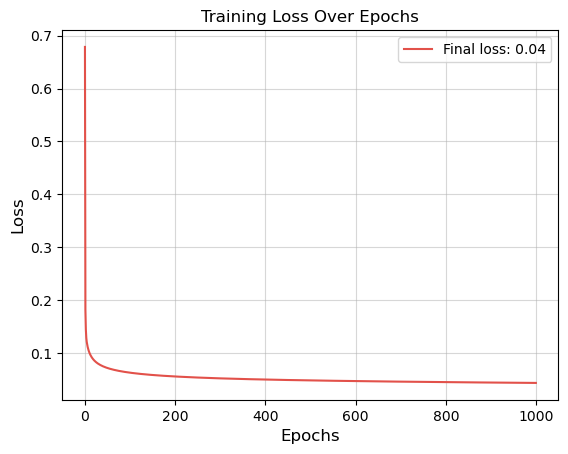

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


data = load_breast_cancer(as_frame=True)

features = data.data
target = data.target



X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=True, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


logistic_custom = CustomLogisticRegression(regularize=True,
                                           regularization_strength=0.01,
                                           regularization_type='l2',
                                           learning_rate=1,
                                          verbose=True, log_every=100).fit(X_train, y_train)

logistic_custom.plot_losses()

# C=100 equals 0.01 learning rate.
logistic_sklearn = LogisticRegression(penalty='l2', C=100).fit(X_train, y_train)

In [13]:
predictions_custom = logistic_custom.predict(X_test)
predictions_sklearn = logistic_sklearn.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_custom = accuracy_score(y_test, predictions_custom)
accuracy_sklearn = accuracy_score(y_test, predictions_sklearn)

precision_sklearn = precision_score(y_test, predictions_custom)
precision_sklearn = precision_score(y_test, predictions_sklearn)

recall_custom = recall_score(y_test, predictions_custom)
recall_sklearn = recall_score(y_test, predictions_sklearn)

In [15]:
# turn the scores into a dataframe
results_df = pd.DataFrame(index=["Accuracy", "Recall", "Precision"],
                          data={
                              "Custom Model": [accuracy_custom, precision_sklearn, recall_custom],
                              "Sklearn Model": [accuracy_sklearn, precision_sklearn, recall_sklearn]
                              }).round(2)

results_df

,Custom Model,Sklearn Model
Accuracy,0.98,0.95
Recall,0.99,0.99
Precision,0.98,0.93


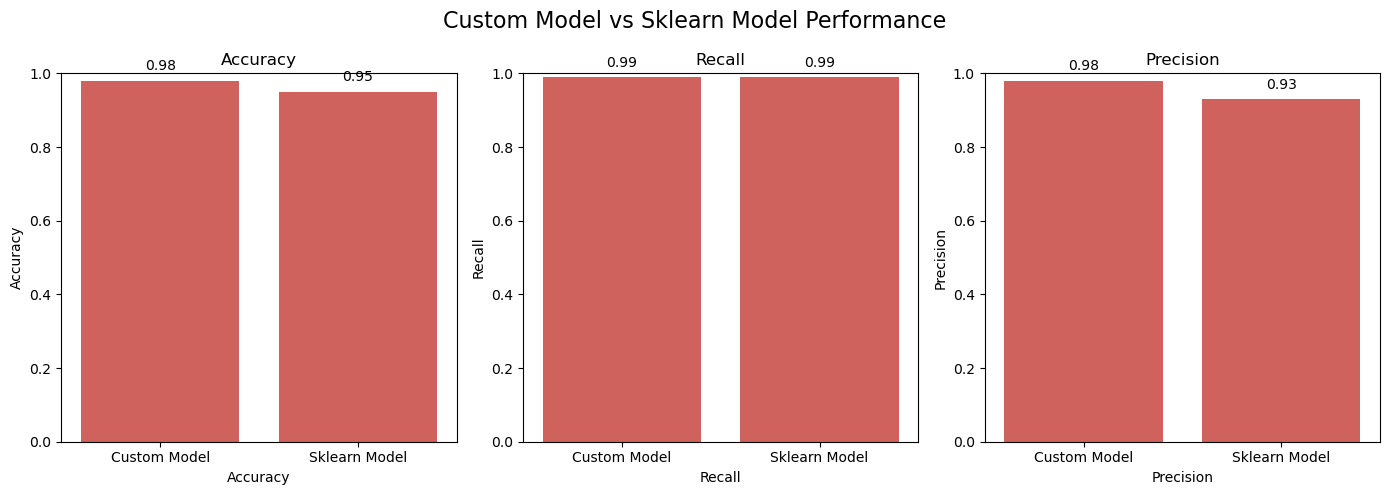

In [16]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

for ax, score in zip(axes, results_df.index):
    sns.barplot(x=results_df.columns, y=results_df.loc[score], ax=ax)
    
    for i, value in enumerate(results_df.loc[score]):
        ax.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel(score)
    ax.set_title(score)
    ax.set_ylim(0, 1)  # since metrics are between 0 and 1

figure.suptitle("Custom Model vs Sklearn Model Performance", fontsize=16)
figure.tight_layout()